Examples of using direct SQL (Spark SQL) vs the orm (Spark Dataframe API)

In [1]:
from pyspark.sql import SparkSession, DataFrame
import pyspark.sql.functions as F
import pyspark.sql.types as T

In [2]:
spark = SparkSession.builder.getOrCreate()

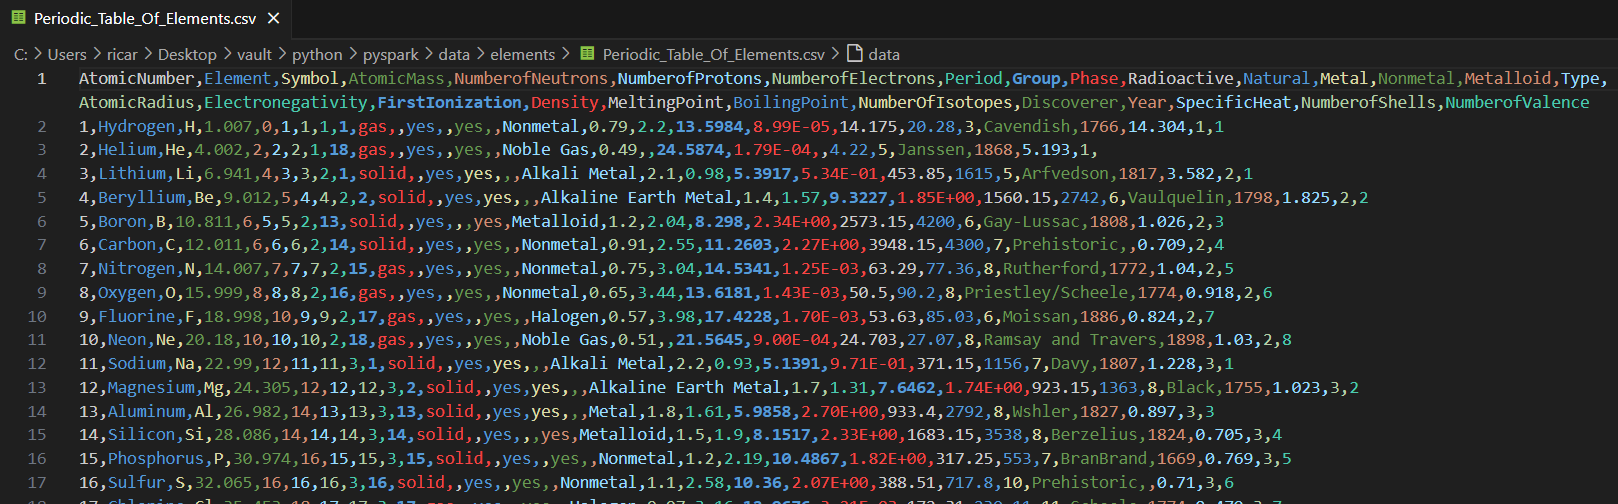

In [3]:
using_GoogleColab = True
if using_GoogleColab:
  # to work with files inside Google Colab,
  from google.colab import drive
  drive.mount('/content/drive')
  # and right-click copy path of the files you want
else:
  # idk man
  pass

Mounted at /content/drive


In [4]:
from pathlib import Path

In [5]:
dir_path = Path("drive/MyDrive/Colab Notebooks/elements")
file_path = dir_path / "Periodic_Table_Of_Elements.csv"

In [6]:
elements = spark.read.csv(
    str(file_path),
    header=True,
    inferSchema=True,
)

In [7]:
elements.show(5)

+------------+---------+------+----------+----------------+---------------+-----------------+------+-----+-----+-----------+-------+-----+--------+---------+--------------------+------------+-----------------+---------------+-------+------------+------------+----------------+----------+----+------------+--------------+---------------+
|AtomicNumber|  Element|Symbol|AtomicMass|NumberofNeutrons|NumberofProtons|NumberofElectrons|Period|Group|Phase|Radioactive|Natural|Metal|Nonmetal|Metalloid|                Type|AtomicRadius|Electronegativity|FirstIonization|Density|MeltingPoint|BoilingPoint|NumberOfIsotopes|Discoverer|Year|SpecificHeat|NumberofShells|NumberofValence|
+------------+---------+------+----------+----------------+---------------+-----------------+------+-----+-----+-----------+-------+-----+--------+---------+--------------------+------------+-----------------+---------------+-------+------------+------------+----------------+----------+----+------------+--------------+------

In [8]:
"""
SELECT
period,
count(*)
FROM elements
WHERE phase = 'liq'
GROUP BY period;
"""
elements.where(F.col("phase") == "liq").groupby("period").count().show()

+------+-----+
|period|count|
+------+-----+
|     6|    1|
|     4|    1|
+------+-----+



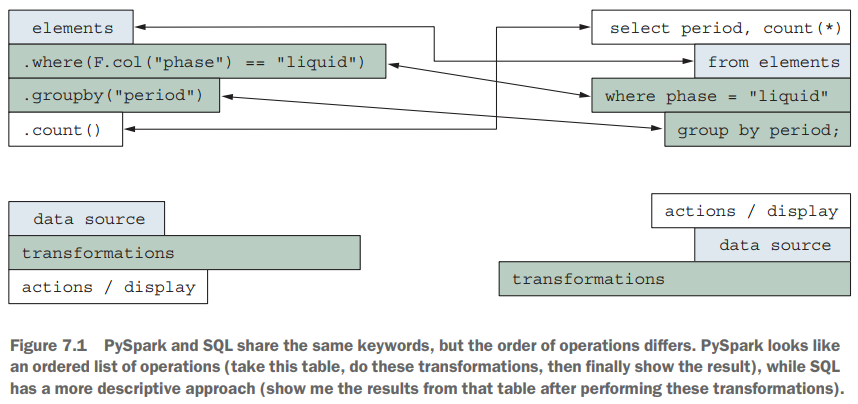

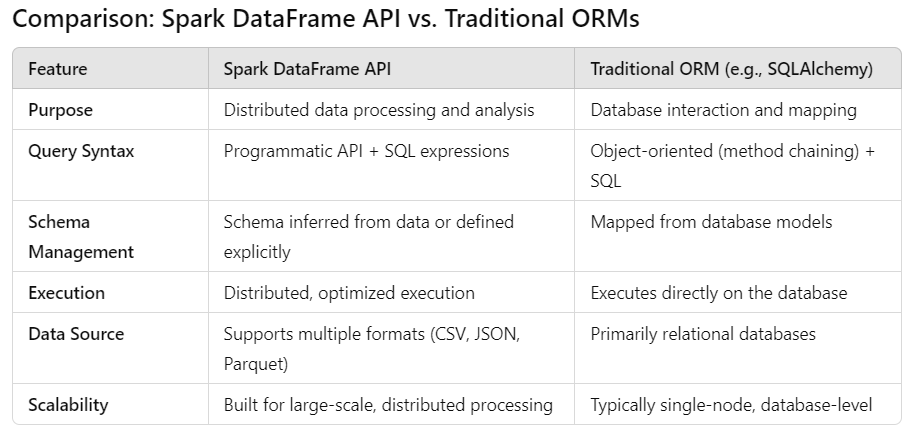

querying a data frame using SQL - spark.sql()

In [9]:
# register a table using the createOrReplaceTempView()
elements.createOrReplaceTempView("elements")

In [10]:
spark.sql(
"select period, count(*) from elements where phase='liq' group by period"
).show()

+------+--------+
|period|count(1)|
+------+--------+
|     6|       1|
|     4|       1|
+------+--------+



PySpark has four methods to create temporary views
* createTempView() - if you call it with a name already being used for another table, the method will fail. Equivalent to `CREATE VIEW`
* createOrReplaceTempView() - if the name already exists, replace the old table with a new one. Equivalent to `CREATE OR REPLACE VIEW`
* createGlobalTempView() - A local table is tied to your SparkSession, while
a global table is tied to the Spark application.
* createOrReplaceGlobalTempView()

Spark catalog
* the Spark catalog is an object that allows working with Spark SQL tables and views. A lot of its methods have to do with managing the metadata of those tables, such as their names and the level of caching

In [11]:
spark.catalog

In [12]:
spark.catalog.listTables()

[Table(name='elements', catalog=None, namespace=[], description=None, tableType='TEMPORARY', isTemporary=True)]

In [13]:
# To delete a view, we use the method dropTempView()
# and pass the name of the view as a parameter.
spark.catalog.dropTempView("elements")

True

In [14]:
spark.catalog.listTables()

[]

Examples...

Example - a school database

In [18]:
import sqlite3

In [19]:
# Create an SQLite database in memory or in a file
conn = sqlite3.connect("school_management.db")  # Replace with ":memory:" for in-memory DB
cursor = conn.cursor()

In [20]:
# SQL script to create schema and insert data
sql_script = """
-- Create Students Table
CREATE TABLE students (
    id INTEGER PRIMARY KEY,
    name TEXT NOT NULL,
    age INTEGER,
    grade INTEGER,
    gender TEXT
);

-- Create Subjects Table
CREATE TABLE subjects (
    id INTEGER PRIMARY KEY,
    name TEXT NOT NULL
);

-- Create Enrollments Table
CREATE TABLE enrollments (
    student_id INTEGER,
    subject_id INTEGER,
    score REAL,
    PRIMARY KEY (student_id, subject_id),
    FOREIGN KEY (student_id) REFERENCES students(id),
    FOREIGN KEY (subject_id) REFERENCES subjects(id)
);

-- Insert Data into Students Table
INSERT INTO students (id, name, age, grade, gender) VALUES
(1, 'Alice', 14, 9, 'F'),
(2, 'Bob', 15, 10, 'M'),
(3, 'Charlie', 13, 8, 'M');

-- Insert Data into Subjects Table
INSERT INTO subjects (id, name) VALUES
(1, 'Mathematics'),
(2, 'Science');

-- Insert Data into Enrollments Table
INSERT INTO enrollments (student_id, subject_id, score) VALUES
(1, 1, 85.0),
(1, 2, 90.0),
(2, 1, 75.0),
(2, 2, 80.0),
(3, 1, 95.0);
"""

In [21]:
# Execute the script
cursor.executescript(sql_script)

# Commit changes and close the connection
conn.commit()

print("Database setup complete!")

Database setup complete!


In [22]:
# Verify the data

# verify the students table
for row in cursor.execute("SELECT * FROM students;"):
    print(row)

(1, 'Alice', 14, 9, 'F')
(2, 'Bob', 15, 10, 'M')
(3, 'Charlie', 13, 8, 'M')


In [25]:
# Close the connection when done
conn.close()

Select all students

In [26]:
import pandas as pd

In [27]:
# Step 1: Connect to the database
conn = sqlite3.connect("school_management.db")

# Load data from SQLite tables into Pandas DataFrames
students_df_pd = pd.read_sql_query("SELECT * FROM students;", conn)
subjects_df_pd = pd.read_sql_query("SELECT * FROM subjects;", conn)
enrollments_df_pd = pd.read_sql_query("SELECT * FROM enrollments;", conn)

# Close the connection
conn.close()

In [28]:
# Step 2: Initialize Spark session
# already done

# Step 3: Convert Pandas DataFrames to Spark DataFrames
students_df_spark = spark.createDataFrame(students_df_pd)
subjects_df_spark = spark.createDataFrame(subjects_df_pd)
enrollments_df_spark = spark.createDataFrame(enrollments_df_pd)

In [29]:
# Step 4: Register Spark DataFrames as Temporary Views
students_df_spark.createOrReplaceTempView("students")
subjects_df_spark.createOrReplaceTempView("subjects")
enrollments_df_spark.createOrReplaceTempView("enrollments")

In [30]:
# querying using Spark SQL

result_df = spark.sql("SELECT * FROM students;")
result_df.show()

+---+-------+---+-----+------+
| id|   name|age|grade|gender|
+---+-------+---+-----+------+
|  1|  Alice| 14|    9|     F|
|  2|    Bob| 15|   10|     M|
|  3|Charlie| 13|    8|     M|
+---+-------+---+-----+------+



In [31]:
# querying using the Spark DataFrame API

students_df = students_df_spark.select("*")
students_df.show()

+---+-------+---+-----+------+
| id|   name|age|grade|gender|
+---+-------+---+-----+------+
|  1|  Alice| 14|    9|     F|
|  2|    Bob| 15|   10|     M|
|  3|Charlie| 13|    8|     M|
+---+-------+---+-----+------+



Filter students by grade

In [32]:
students_df = spark.sql("SELECT * FROM students WHERE grade = 9")
students_df.show()

+---+-----+---+-----+------+
| id| name|age|grade|gender|
+---+-----+---+-----+------+
|  1|Alice| 14|    9|     F|
+---+-----+---+-----+------+



In [33]:
students_df = students_df_spark.filter(students_df_spark.grade == 9)
students_df.show()

+---+-----+---+-----+------+
| id| name|age|grade|gender|
+---+-----+---+-----+------+
|  1|Alice| 14|    9|     F|
+---+-----+---+-----+------+



Aggregate - average score per student

In [34]:
avg_scores_df = spark.sql("""
    SELECT student_id, AVG(score) as average_score
    FROM enrollments
    GROUP BY student_id
""")
avg_scores_df.show()

+----------+-------------+
|student_id|average_score|
+----------+-------------+
|         1|         87.5|
|         3|         95.0|
|         2|         77.5|
+----------+-------------+



In [35]:
avg_scores_df = enrollments_df_spark.groupBy("student_id").agg(F.avg("score").alias("average_score"))
avg_scores_df.show()

+----------+-------------+
|student_id|average_score|
+----------+-------------+
|         1|         87.5|
|         3|         95.0|
|         2|         77.5|
+----------+-------------+



Join - Students with their scores in science

In [36]:
science_scores_df = spark.sql("""
    SELECT s.name, e.score
    FROM students s
    JOIN enrollments e ON s.id = e.student_id
    WHERE e.subject_id = 2
""")
science_scores_df.show()

+-----+-----+
| name|score|
+-----+-----+
|Alice| 90.0|
|  Bob| 80.0|
+-----+-----+



In [37]:
science_scores_df = students_df_spark.join(
    enrollments_df_spark, students_df_spark.id == enrollments_df_spark.student_id
).filter(enrollments_df_spark.subject_id == 2).select(students_df_spark.name, enrollments_df_spark.score)
science_scores_df.show()

+-----+-----+
| name|score|
+-----+-----+
|Alice| 90.0|
|  Bob| 80.0|
+-----+-----+



Count - Total students per grade

In [38]:
students_per_grade_df = spark.sql("""
    SELECT grade, COUNT(*) as total_students
    FROM students
    GROUP BY grade
""")
students_per_grade_df.show()

+-----+--------------+
|grade|total_students|
+-----+--------------+
|    9|             1|
|   10|             1|
|    8|             1|
+-----+--------------+



In [39]:
students_per_grade_df = students_df_spark.groupBy("grade").agg(F.count("*").alias("total_students"))
students_per_grade_df.show()

+-----+--------------+
|grade|total_students|
+-----+--------------+
|    9|             1|
|   10|             1|
|    8|             1|
+-----+--------------+



Find students with scores above 80 in any subject

In [40]:
high_scorers_df = spark.sql("""
    SELECT DISTINCT s.name
    FROM students s
    JOIN enrollments e ON s.id = e.student_id
    WHERE e.score > 80
""")
high_scorers_df.show()

+-------+
|   name|
+-------+
|Charlie|
|  Alice|
+-------+



In [41]:
high_scorers_df = students_df_spark.join(
    enrollments_df_spark, students_df_spark.id == enrollments_df_spark.student_id
).filter(enrollments_df_spark.score > 80).select(students_df_spark.name).distinct()
high_scorers_df.show()

+-------+
|   name|
+-------+
|Charlie|
|  Alice|
+-------+



Students and their subjects

In [42]:
student_subjects_df = spark.sql("""
    SELECT s.name as student_name, sub.name as subject_name
    FROM students s
    JOIN enrollments e ON s.id = e.student_id
    JOIN subjects sub ON e.subject_id = sub.id
""")
student_subjects_df.show()

+------------+------------+
|student_name|subject_name|
+------------+------------+
|     Charlie| Mathematics|
|         Bob| Mathematics|
|       Alice| Mathematics|
|         Bob|     Science|
|       Alice|     Science|
+------------+------------+



In [43]:
student_subjects_df = students_df_spark.join(
    enrollments_df_spark, students_df_spark.id == enrollments_df_spark.student_id
).join(
    subjects_df_spark, enrollments_df_spark.subject_id == subjects_df_spark.id
).select(
    students_df_spark.name.alias("student_name"), subjects_df_spark.name.alias("subject_name")
)
student_subjects_df.show()

+------------+------------+
|student_name|subject_name|
+------------+------------+
|     Charlie| Mathematics|
|         Bob| Mathematics|
|       Alice| Mathematics|
|         Bob|     Science|
|       Alice|     Science|
+------------+------------+



Rank students by average score

In [44]:
spark.sql("""
    WITH avg_scores AS (
        SELECT student_id, AVG(score) as avg_score
        FROM enrollments
        GROUP BY student_id
    )
    SELECT student_id, avg_score, RANK() OVER (ORDER BY avg_score DESC) as rank
    FROM avg_scores
""").show()

+----------+---------+----+
|student_id|avg_score|rank|
+----------+---------+----+
|         3|     95.0|   1|
|         1|     87.5|   2|
|         2|     77.5|   3|
+----------+---------+----+



In [45]:
from pyspark.sql.window import Window

In [46]:
windowSpec = Window.orderBy(F.desc("avg_score"))

avg_scores_df = enrollments_df_spark.groupBy("student_id").agg(F.avg("score").alias("avg_score"))
ranked_students_df = avg_scores_df.withColumn("rank", F.rank().over(windowSpec))
ranked_students_df.show()

+----------+---------+----+
|student_id|avg_score|rank|
+----------+---------+----+
|         3|     95.0|   1|
|         1|     87.5|   2|
|         2|     77.5|   3|
+----------+---------+----+



Example - Sakila database

* sakila-data.sql - contains the data inserts.
* sakila-schema.sql - defines the database schema.
* sakila.mwb - a MySQL Workbench model of the Sakila database.

In [15]:
dir_path = Path("drive/MyDrive/Colab Notebooks/sakila-db")
schema_path = dir_path / 'sakila-schema.sql'
data_path = dir_path / 'sakila-data.sql'
model_path = dir_path / 'sakila.mwb'

In [16]:
# Load the schema and data files for inspection
with open(schema_path, 'r') as schema_file:
    sakila_schema = schema_file.read()

with open(data_path, 'r') as data_file:
    sakila_data = data_file.read()

In [17]:
# Output a small part of each file
sakila_schema[:1000], sakila_data[:1000]

('-- Sakila Sample Database Schema\n-- Version 1.5\n\n-- Copyright (c) 2006, 2025, Oracle and/or its affiliates.\n\n-- Redistribution and use in source and binary forms, with or without\n-- modification, are permitted provided that the following conditions are\n-- met:\n\n-- * Redistributions of source code must retain the above copyright notice,\n--   this list of conditions and the following disclaimer.\n-- * Redistributions in binary form must reproduce the above copyright\n--   notice, this list of conditions and the following disclaimer in the\n--   documentation and/or other materials provided with the distribution.\n-- * Neither the name of Oracle nor the names of its contributors may be used\n--   to endorse or promote products derived from this software without\n--   specific prior written permission.\n\n-- THIS SOFTWARE IS PROVIDED BY THE COPYRIGHT HOLDERS AND CONTRIBUTORS "AS\n-- IS" AND ANY EXPRESS OR IMPLIED WARRANTIES, INCLUDING, BUT NOT LIMITED TO,\n-- THE IMPLIED WARRAN

Anyway, run that, following these steps https://dev.mysql.com/doc/sakila/en/sakila-installation.html

Nvm, i'll do this in a separate notebook, with a docker setup and a mysql or mariadb database